# DINOv2 Analysis - Image and Embedding Loading

This notebook extracts embeddings using pre-trained DINOv2 models from HuggingFace.
It uses the same data and analysis pipeline as the BYOL notebook, but with DINOv2 features.

In [1]:
%cd ../

/Users/kadofong/work/projects/merian/pieridae/scripts/dino


In [2]:
import os
import sys
import torch
import numpy as np
import yaml
from pathlib import Path
from tqdm import tqdm
import logging
import glob
import pickle
import pandas as pd
from transformers import AutoImageProcessor, AutoModel
from PIL import Image

print("📦 Imports completed successfully")

📦 Imports completed successfully


## Device Setup

Configure device with MPS (Apple Silicon) support if available.

In [3]:
def setup_device():
    """Setup device with MPS support for Apple Silicon"""
    if torch.backends.mps.is_available():
        device = torch.device('mps')
        print(f"✅ Using Apple Silicon GPU (MPS): {device}")
        # Set memory fraction to avoid OOM on limited GPU memory
        torch.mps.set_per_process_memory_fraction(0.8)
    elif torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"✅ Using NVIDIA GPU: {device}")
    else:
        device = torch.device('cpu')
        print(f"Using CPU: {device}")
        # Optimize CPU performance
        torch.set_num_threads(os.cpu_count())
    
    return device

device = setup_device()

✅ Using Apple Silicon GPU (MPS): mps


## Configuration Loading

Load configuration from the YAML file.

In [4]:
def load_config(config_path: str):
    """Load configuration from YAML file"""
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    return config

# Load configuration
config_path = 'dino_config.yaml'
config = load_config(config_path)

# Convert paths to Path objects
config['data']['input_path'] = Path(config['data']['input_path'])
config['data']['output_path'] = Path(config['data']['output_path'])

print(f"📋 Configuration loaded from: {config_path}")
print(f"📁 Input path: {config['data']['input_path']}")
print(f"📁 Output path: {config['data']['output_path']}")
print(f"🖼️  Image size: {config['model']['image_size']}")
print(f"🤖 DINOv2 model: {config['model']['model_name']}")
print(f"🔧 Fine-tuning enabled: {config['model']['enable_finetuning']}")

📋 Configuration loaded from: dino_config.yaml
📁 Input path: ../../local_data/pieridae_output/starlet/msorabove_v0
📁 Output path: ../../local_data/dino_results
🖼️  Image size: 150
🤖 DINOv2 model: facebook/dinov2-base
🔧 Fine-tuning enabled: False


## Data Loading

Load images using the same pattern as the BYOL analysis script.

In [5]:
def load_data(data_path: Path):
    """Load image data from pickle files (same as cluster script)"""
    print(f"🔍 Loading image data from: {data_path}")
    
    pattern = f"{data_path}/M*/*i_results.pkl"
    filenames = glob.glob(pattern)
    
    if not filenames:
        raise FileNotFoundError(f"No files found matching pattern: {pattern}")
    
    print(f"📸 Found {len(filenames)} image files")
    
    imgs = []
    img_names = []
    
    for fname in tqdm(filenames, desc="Loading images"):
        img = []
        for band in 'gi':
            current_filename = fname.replace('_i_', f'_{band}_')
            
            try:
                with open(current_filename, 'rb') as f:
                    xf = pickle.load(f)
                    img.append(xf['image'])
                    if band == 'i':
                        img.append(xf['hf_image'])
            except FileNotFoundError:
                print(f"⚠️  File not found: {current_filename}")
                continue
        
        if len(img) == 3:  # Only add if we have all bands
            imgs.append(np.array(img))
            img_names.append(Path(fname).parent.name)
    
    images = np.array(imgs)
    img_names = np.array(img_names)
    
    print(f"✅ Loaded {len(images)} images with shape: {images.shape}")
    return images, img_names

# Load images
images, img_names = load_data(config['data']['input_path'])

🔍 Loading image data from: ../../local_data/pieridae_output/starlet/msorabove_v0
📸 Found 22913 image files


Loading images: 100%|████████████████████| 22913/22913 [00:43<00:00, 526.01it/s]


✅ Loaded 22913 images with shape: (22913, 3, 150, 150)


## DINOv2 Model Setup

Initialize the DINOv2 model from HuggingFace.

Available models:
- `facebook/dinov2-small`: 384-dim embeddings (21M params)
- `facebook/dinov2-base`: 768-dim embeddings (86M params)
- `facebook/dinov2-large`: 1024-dim embeddings (0.3B params)
- `facebook/dinov2-giant`: 1536-dim embeddings (1.1B params)

In [6]:
def setup_dinov2_model(config, device):
    """Setup DINOv2 model for inference"""
    print(f"🤖 Setting up DINOv2 model: {config['model']['model_name']}...")
    
    # Load image processor and model from HuggingFace
    processor = AutoImageProcessor.from_pretrained(config['model']['model_name'])
    model = AutoModel.from_pretrained(config['model']['model_name'])
    
    # Move model to device
    model = model.to(device)
    
    # Set to eval mode (no training by default)
    if not config['model']['enable_finetuning']:
        model.eval()
        print("🔒 Model set to evaluation mode (no fine-tuning)")
    else:
        print("⚠️  Fine-tuning mode enabled (not yet implemented)")
        # TODO: Implement fine-tuning logic here
        # This would include:
        # - Adding a classification head if needed
        # - Freezing backbone layers if config['model']['finetuning']['freeze_backbone'] is True
        # - Setting up optimizer and loss function
        # - Creating training loop
        pass
    
    print(f"✅ DINOv2 model setup complete on {device}")
    return processor, model

# Setup model
processor, model = setup_dinov2_model(config, device)

🤖 Setting up DINOv2 model: facebook/dinov2-base...


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/ipykernel/iostream.py:153: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x30fdff700>
  self._event_pipes[threading.current_thread()] = event_pipe
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/ipykernel/iostream.py:153: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x30fdfdc00>
  self._event_pipes[threading.current_thread()] = event_pipe
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/ipykernel/iostream.py:153: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x30fdff160>
  self._event_pipes[threading.current_thread()] = event_pipe
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/ipykernel/iostream.py:153: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x30fdffbe0>
  self._event_pipes[threading.current_thread()] = event_pipe
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/ipyk

🔒 Model set to evaluation mode (no fine-tuning)
✅ DINOv2 model setup complete on mps


## Extract Embeddings

Extract embeddings from all loaded images using the DINOv2 model.

DINOv2 outputs:
- CLS token embedding (global image representation)
- Patch embeddings (spatial features)

We use the CLS token as the image embedding.

In [7]:
def prepare_images_for_dinov2(images_batch):
    """Convert numpy arrays to PIL images for DINOv2 processor"""
    # images_batch shape: (batch_size, 3, H, W)
    # Need to convert to list of PIL images
    pil_images = []
    
    for img in images_batch:
        # Transpose from (3, H, W) to (H, W, 3)
        img_hwc = np.transpose(img, (1, 2, 0))
        
        # Normalize to 0-255 range if needed
        if img_hwc.max() <= 1.0:
            img_hwc = (img_hwc * 255).astype(np.uint8)
        else:
            # Scale to 0-255 based on data range
            img_hwc = img_hwc.astype(np.float32)
            img_min, img_max = img_hwc.min(), img_hwc.max()
            if img_max > img_min:
                img_hwc = ((img_hwc - img_min) / (img_max - img_min) * 255).astype(np.uint8)
            else:
                img_hwc = np.zeros_like(img_hwc, dtype=np.uint8)
        
        # Convert to PIL Image
        pil_img = Image.fromarray(img_hwc)
        pil_images.append(pil_img)
    
    return pil_images

def extract_embeddings(model, processor, images, device, batch_size=128):
    """Extract embeddings from images using DINOv2 model"""
    print(f"🧠 Extracting embeddings from {len(images)} images...")
    
    model.eval()
    all_embeddings = []
    
    # Adjust batch size for device capabilities
    if device.type == 'mps':
        batch_size = min(32, batch_size)  # Reduce for MPS
    elif device.type == 'cpu':
        batch_size = min(16, batch_size)  # Further reduce for CPU
    
    num_batches = (len(images) + batch_size - 1) // batch_size
    
    with torch.no_grad():
        for i in tqdm(range(num_batches), desc="Extracting embeddings"):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(images))
            
            # Prepare batch of images
            batch_numpy = images[start_idx:end_idx]
            pil_images = prepare_images_for_dinov2(batch_numpy)
            
            try:
                # Process images
                inputs = processor(images=pil_images, return_tensors="pt")
                inputs = {k: v.to(device) for k, v in inputs.items()}
                
                # Extract embeddings
                outputs = model(**inputs)
                
                # Get CLS token embeddings (first token)
                cls_embeddings = outputs.last_hidden_state[:, 0, :]
                
                all_embeddings.append(cls_embeddings.cpu().numpy())
                
            except RuntimeError as e:
                if "MPS" in str(e) and device.type == 'mps':
                    print(f"⚠️  MPS error, falling back to CPU for batch {i}")
                    # Fallback to CPU for this batch
                    inputs = {k: v.cpu() for k, v in inputs.items()}
                    model_cpu = model.cpu()
                    outputs = model_cpu(**inputs)
                    cls_embeddings = outputs.last_hidden_state[:, 0, :]
                    all_embeddings.append(cls_embeddings.cpu().numpy())
                    # Move model back to original device
                    model = model.to(device)
                else:
                    raise e
    
    # Combine all embeddings
    embeddings = np.vstack(all_embeddings)
    print(f"✅ Extracted embeddings shape: {embeddings.shape}")
    
    return embeddings

# Extract embeddings
embeddings = extract_embeddings(
    model, 
    processor,
    images, 
    device, 
    batch_size=config['inference']['batch_size']
)

🧠 Extracting embeddings from 22913 images...


Extracting embeddings: 100%|██████████████████| 717/717 [09:28<00:00,  1.26it/s]


✅ Extracted embeddings shape: (22913, 768)


## Dimensionality Reduction (PCA + UMAP)

Apply PCA and UMAP to the embeddings for visualization.

In [8]:
import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def compute_pca_umap(embeddings, config):
    """Apply PCA and UMAP to embeddings"""
    print("🔄 Computing PCA and UMAP...")
    
    # Clean data
    embeddings_clean = np.nan_to_num(
        embeddings, nan=0.0, posinf=0.0, neginf=0.0
    )
    
    # Standardization
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(embeddings_clean)
    
    # PCA
    pca_components = config['analysis']['pca_components']
    if pca_components is None:
        # Auto-determine based on variance threshold
        pca_full = PCA()
        pca_full.fit(embeddings_scaled)
        cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
        threshold = config['analysis']['explained_variance_threshold']
        pca_components = np.argmax(cumsum_var >= threshold) + 1
    
    max_components = min(
        embeddings_scaled.shape[0] - 1,
        embeddings_scaled.shape[1]
    )
    pca_components = min(pca_components, max_components)
    
    pca = PCA(n_components=pca_components, random_state=42)
    embeddings_pca = pca.fit_transform(embeddings_scaled)
    
    # UMAP
    n_neighbors = min(
        config['analysis']['n_neighbors'],
        len(embeddings_pca) - 1
    )
    
    umap_reducer = umap.UMAP(
        n_components=config['analysis']['umap_components'],
        n_neighbors=n_neighbors,
        min_dist=config['analysis']['min_dist'],
        metric=config['analysis']['metric'],
        random_state=42,
        verbose=True
    )
    
    embeddings_umap = umap_reducer.fit_transform(embeddings_pca)
    
    print(f"✅ PCA components: {pca_components}")
    print(f"✅ UMAP embedding shape: {embeddings_umap.shape}")
    
    return {
        'scaler': scaler,
        'pca': pca,
        'umap': umap_reducer,
        'embeddings_original': embeddings_clean,
        'embeddings_pca': embeddings_pca,
        'embeddings_umap': embeddings_umap
    }

# Compute PCA and UMAP
reduction_results = compute_pca_umap(embeddings, config)

/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


🔄 Computing PCA and UMAP...


/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(min_dist=0.01, n_jobs=1, random_state=42, verbose=True)
Sat Oct  4 07:18:52 2025 Construct fuzzy simplicial set
Sat Oct  4 07:18:52 2025 Finding Nearest Neighbors
Sat Oct  4 07:18:52 2025 Building RP forest with 13 trees
Sat Oct  4 07:18:55 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Oct  4 07:19:01 2025 Finished Nearest Neighbor Search
Sat Oct  4 07:19:02 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Oct  4 07:19:14 2025 Finished embedding
✅ PCA components: 50
✅ UMAP embedding shape: (22913, 2)


## Load Classification Labels

Load the classification labels for creating the fraction maps.

In [16]:
def load_labels(config, img_names):
    """Load classification labels"""
    labels = None
    label_file = Path(config.get('labels', {}).get('classifications_file', './classifications_kadofong_current.csv'))
    
    if label_file.exists() and img_names is not None:
        try:
            mergers = pd.read_csv(label_file, index_col=0)
            labels = mergers.reindex(img_names)
            labels = labels.replace(np.nan, 0).values.flatten().astype(int)
            print(f"✅ Loaded classification labels: {len(labels)} objects")
            
            # Print label distribution
            unique, counts = np.unique(labels, return_counts=True)
            label_meanings = {
                0: "unclassified", 1: "undisturbed", 2: "ambiguous",
                3: "merger", 4: "fragmentation", 5: "artifact"
            }
            
            print("📊 Label distribution:")
            for label_val, count in zip(unique, counts):
                meaning = label_meanings.get(label_val, f"unknown_{label_val}")
                print(f"   {label_val} ({meaning}): {count} objects")
                
        except Exception as e:
            print(f"⚠️  Could not load labels: {e}")
            labels = None
    else:
        print(f"⚠️  Label file not found: {label_file}")
        labels = None
    
    return labels

# Load labels
labels = load_labels(config, img_names)

✅ Loaded classification labels: 22913 objects
📊 Label distribution:
   0 (unclassified): 20281 objects
   1 (undisturbed): 2004 objects
   2 (ambiguous): 207 objects
   3 (merger): 94 objects
   4 (fragmentation): 278 objects
   5 (artifact): 49 objects


# Use PCA to estimate labels

In [10]:
import matplotlib.pyplot as plt
from astropy.visualization import make_lupton_rgb
from matplotlib import colors
from ekfplot import plot as ek
from scipy import ndimage

from sklearn.neighbors import NearestNeighbors

In [11]:
pca = reduction_results['pca']
print(f'Explained variance: {pca.explained_variance_ratio_.sum()*100:.1f} pct')

Explained variance: 87.0 pct


In [12]:
pca_embeddings = reduction_results['embeddings_pca']

nbrs = NearestNeighbors(n_neighbors=50, algorithm='ball_tree').fit(pca_embeddings)

distances, indices = nbrs.kneighbors(pca_embeddings)
distances[:,0] = np.nan

In [13]:
n_min = config.get('labels', {}).get('minimum_labeled_neighbors', 8)
print(f'Using minimum_labeled_neighbors = {n_min} from config')

Using minimum_labeled_neighbors = 8 from config


In [17]:
neighbor_labels = labels[indices]

weights = np.where( neighbor_labels>0, 1./distances, 0. )
weights /= np.nansum(weights,axis=1).reshape(-1,1)

prob_labels = np.zeros([pca_embeddings.shape[0], labels.max()+1])

for ix in range(labels.max()+1):
    prob_labels[:,ix] = np.nansum(np.where(neighbor_labels==ix, weights, 0),axis=1)
n_labels = np.sum(neighbor_labels>0,axis=1)


prob_labels[n_labels<n_min] = 0.
print(f'{(prob_labels>0).any(axis=1).sum()} galaxies have auto-labels')

4898 galaxies have auto-labels


/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_84893/1701886768.py:4: RuntimeWarning: invalid value encountered in divide
  weights /= np.nansum(weights,axis=1).reshape(-1,1)


In [18]:
# iterate over relatively certain labels
iterative_labels = labels.copy ()

n_labeled = (iterative_labels>0).sum()


additions = np.where(prob_labels[n_labels>=n_min] > 0.6)
new_labels = np.zeros_like(iterative_labels)
new_labels[additions[0]] = additions[1]

new_labels[(prob_labels[:,4]>0.1)&(n_labels>=n_min)] = 4


iterative_labels[iterative_labels==0] = new_labels[iterative_labels==0]
n_new = (iterative_labels>0).sum() - n_labeled
print(f'{(labels>0).sum()} human labels')
print(f'{n_new} auto-labels added, {(iterative_labels>0).sum()} labels total')

2632 human labels
4432 auto-labels added, 7064 labels total


In [19]:
neighbor_labels = iterative_labels[indices]

weights = np.where( neighbor_labels>0, 1./distances, 0. )
weights /= np.nansum(weights,axis=1).reshape(-1,1)

prob_labels = np.zeros([pca_embeddings.shape[0], labels.max()+1])

for ix in range(labels.max()+1):
    prob_labels[:,ix] = np.nansum(np.where(neighbor_labels==ix, weights, 0),axis=1)
n_labels = np.sum(neighbor_labels>0,axis=1)

prob_labels[n_labels<n_min] = 0.
print(f'{(prob_labels>0).any(axis=1).sum()} galaxies have auto-labels')

22415 galaxies have auto-labels


In [26]:
is_merger = ((prob_labels[:,2]+prob_labels[:,3])>0.25)&(prob_labels[:,4]<0.1)

/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_84893/1396890995.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['','undisturbed','ambiguous','merger','fragmented'], rotation=35)


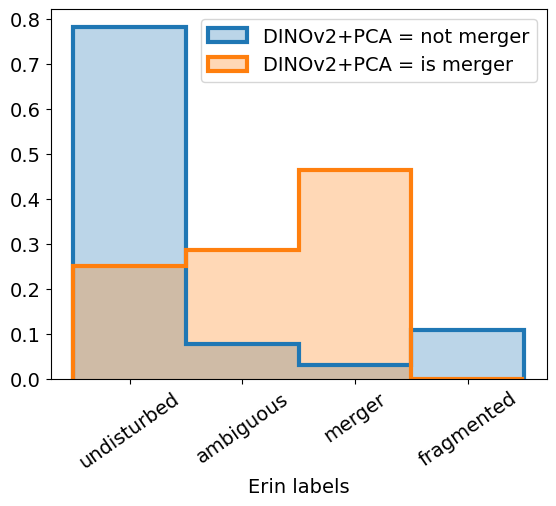

In [28]:
ax = plt.subplot(111)
ek.hist(labels[~is_merger], bins=np.arange(0.5,5), density=True, lw=3, alpha=0.3, label='DINOv2+PCA = not merger')
ek.hist(labels[is_merger], bins=np.arange(.5,5), density=True, lw=3, alpha=0.3, label='DINOv2+PCA = is merger')
ax.set_xticklabels(['','undisturbed','ambiguous','merger','fragmented'], rotation=35)
ax.set_xlabel('Erin labels')
plt.legend ()

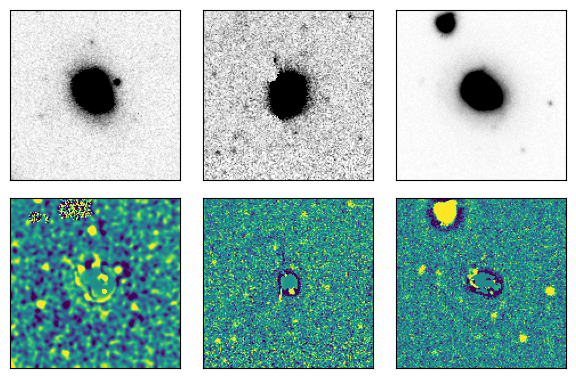

In [29]:
fig, axarr = plt.subplots(2,3,figsize=(6,4))

for aix,idx in enumerate(range(3)):
    ek.imshow(images[(labels==1)&is_merger][idx,1], ax=axarr[0,aix], q=0.05, cmap='Greys')
    ek.imshow(images[(labels==1)&is_merger][idx,2], ax=axarr[1,aix])

for ax in axarr.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout ()

In [32]:
candidates

array([], dtype=int64)

<Axes: >

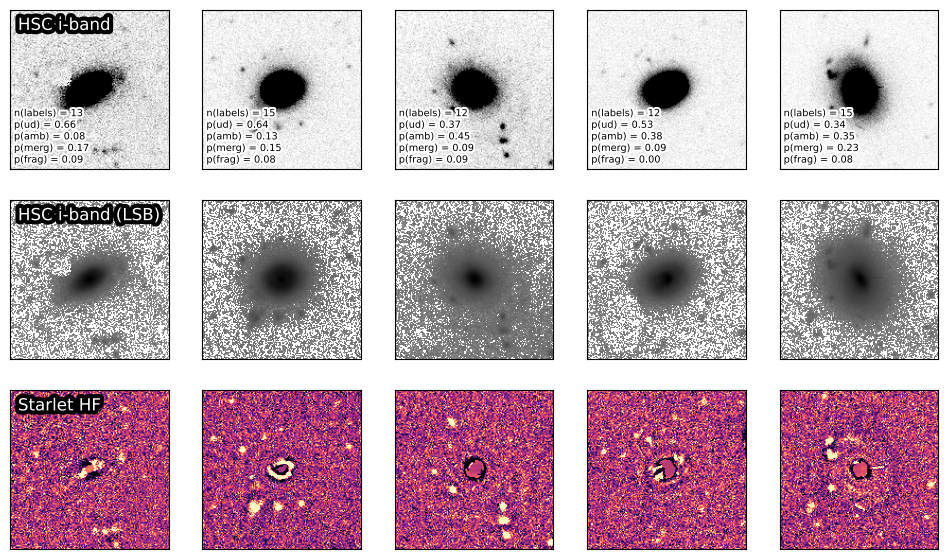

In [47]:
fig, axarr = plt.subplots(3, 5, figsize=(12,7))

fragmented = prob_labels[:,4] > 0.1
possible_merger = (prob_labels[:,2]+prob_labels[:,3]) > 0.25

candidates = np.arange(prob_labels.shape[0])[possible_merger&~fragmented][10:]
for idx, gix in enumerate(candidates[:5]):
    ek.imshow(
        images[gix][1],
        ax=axarr[0, idx],
        q=0.05,
        cmap='Greys'
    )
    axarr[1,idx].imshow(
        ndimage.gaussian_filter(images[gix][1], 0),
        origin='lower',
        cmap='Greys',
        norm=colors.LogNorm()
    )
    ek.imshow(
        images[gix][2],
        ax=axarr[2, idx],
        cmap='magma'
    )
    ek.text(
        0.025,
        0.025,
        f'''n(labels) = {n_labels[gix]}
p(ud) = {prob_labels[gix,1]:.2f}
p(amb) = {prob_labels[gix,2]:.2f}
p(merg) = {prob_labels[gix,3]:.2f}
p(frag) = {prob_labels[gix,4]:.2f}''',
        ax=axarr[0,idx],
        fontsize=7, bordercolor='w', color='k', borderwidth=3
    )

for ax in axarr.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

ek.text(0.05,0.95, 'HSC i-band', ax=axarr[0,0], fontsize=12, bordercolor='k', color='w', borderwidth=6 )
ek.text(0.05,0.95, 'HSC i-band (LSB)', ax=axarr[1,0], fontsize=12, bordercolor='k', color='w', borderwidth=6 )
ek.text(0.05,0.95, 'Starlet HF', ax=axarr[2,0], fontsize=12, bordercolor='k', color='w', borderwidth=6 )

# Look at merger statistics

In [34]:
from ekfplot import colors as ec, plot as ek
from ekfphys import calibrations
from pieridae.starbursts import sample


In [35]:
base_catalog, masks = sample.load_sample(
    '/Users/kadofong/work/projects/merian/local_data/base_catalogs/mdr1_n708maglt26_and_pzgteq0p1.parquet'
)

/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/work/projects/merian/carpenter/src/carpenter/emission.py:338: RuntimeWarning: divide by zero encountered in reciprocal
  emission_correction = correct_NIISII(redshift_values, aperture_corrected_logmass)**-1


Computed aperture correction in 0.0 seconds.
Computed line contamination correction in 0.0 seconds.
Loading precomputed Galactic extinction map...
Interpolated Galactic extinction values from map.
Computed Galactic extinction correction in 0.7 seconds.
Computed internal extinction corrections in 0.7 seconds.


/Users/kadofong/work/projects/merian/agrias/python/agrias/photometry.py:115: RuntimeWarning: invalid value encountered in log10
  lsq_y = np.log10(np.array([ fdict[band] for band in plawbands ]))
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [36]:
fragmented = prob_labels[:,4] > 0.1
prob_merger = (prob_labels[:,2]+prob_labels[:,3])

In [37]:
catalog = base_catalog.reindex(img_names[~fragmented])
catalog['p_merger'] = np.where((prob_labels[~fragmented]==0).all(axis=1), np.nan, prob_labels[~fragmented,3])
catalog['p_ambig'] = np.where((prob_labels[~fragmented]==0).all(axis=1), np.nan, prob_labels[~fragmented,2])
catalog['p_undisturbed'] = np.where((prob_labels[~fragmented]==0).all(axis=1), np.nan, prob_labels[~fragmented,1])

/Users/kadofong/work/ekfutils/ekfplot/ekfplot/plot.py:494: RuntimeWarning: invalid value encountered in divide
  im=ax.pcolormesh(bins[0], bins[1], (weighted_counts/raw_counts).T, cmap=cmap, **kwargs)


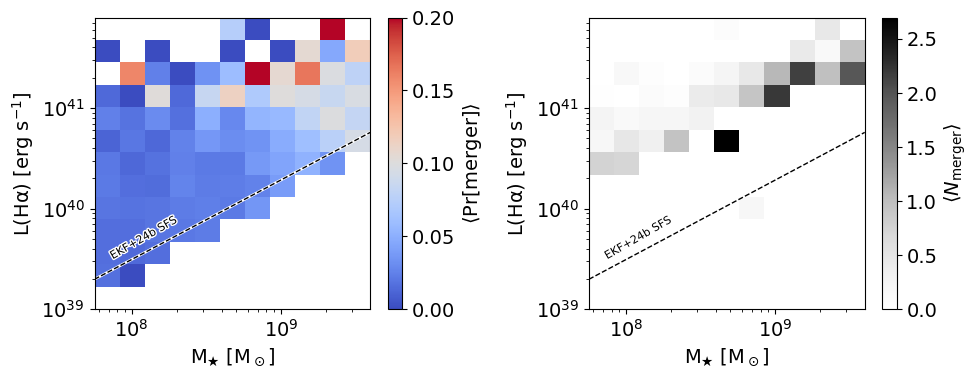

In [38]:
fig, axarr = plt.subplots(1,2,figsize=(10,4))

bins = [np.logspace(7.75, 9.6,12), np.logspace(39,41.9,14)]
im,_=ek.pcolor_avg2d(
    10.**catalog['logmass'], 
    catalog['L_Ha'],
    catalog['p_merger']+catalog['p_ambig'],
    cmap='coolwarm',
    yscale='log',
    xscale='log',
    bins=bins,
    ax=axarr[0],
    vmax=0.2
)

imx=ek.hist2d(
    10.**catalog['logmass'], 
    catalog['L_Ha'],
    weights=catalog['p_merger']+catalog['p_ambig'],
    cmap='Greys',
    yscale='log',
    xscale='log',
    bins=bins,
    ax=axarr[1]
)

ms = im._coordinates.data[0,:,0]
alpha = -0.13*0.08 + 0.8
norm = 1.24*0.08 - 1.47
sfs = 10.**(alpha*(np.log10(ms) - 8.5) + norm)
ha_sfs = calibrations.SFR2LHa(sfs)
plt.colorbar(imx[0][-1],ax=axarr[1], label=r'$\langle N_{\rm merger} \rangle$')

plt.colorbar(im,ax=axarr[0], label=r'$\langle {\rm Pr[merger]}\rangle$')

for ax in axarr:
    ek.outlined_plot(
        ms,
        ha_sfs,
        ax=ax,
        lw=1,
        ls='--',
    )
    
    ek.text(
        7e7,
        3e39,
        'EKF+24b SFS',
        ax=ax,
        rotation=30,
        coord_type='absolute',
        va='bottom',
        ha='left',
        bordercolor='w',
        borderwidth=2,
        fontsize=8
    )    
    ax.set_xlabel(ek.common_labels['mstar'])
    ax.set_ylabel(ek.common_labels['halum'])
    ek.loglog(ax=ax)

plt.tight_layout ()

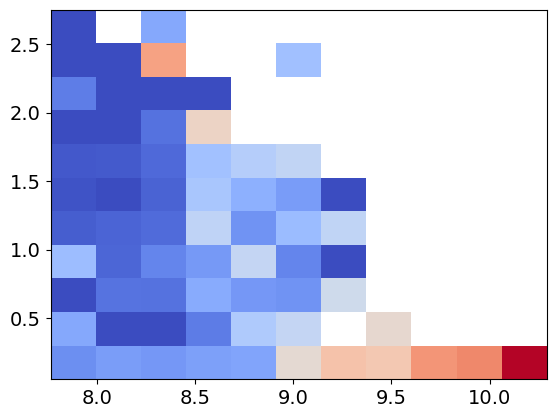

In [39]:
im,_=ek.pcolor_avg2d(
    catalog['logmass'], 
    catalog['z_spec'],
    catalog['p_merger']+catalog['p_ambig'],
    cmap='coolwarm',
    zscale='linear',
    bins=12
)

In [40]:
logmstar_bins = np.arange(7.75,10.,0.25)

In [41]:
groups = np.digitize(catalog['logmass'], logmstar_bins)

In [42]:
alpha = -0.13*0.08 + 0.8
norm = 1.24*0.08 - 1.47
sfs_at_mass = 10.**(alpha*(catalog['logmass'] - 8.5) + norm)
ha_sfs_at_mass = calibrations.SFR2LHa(sfs_at_mass)

<Axes: >

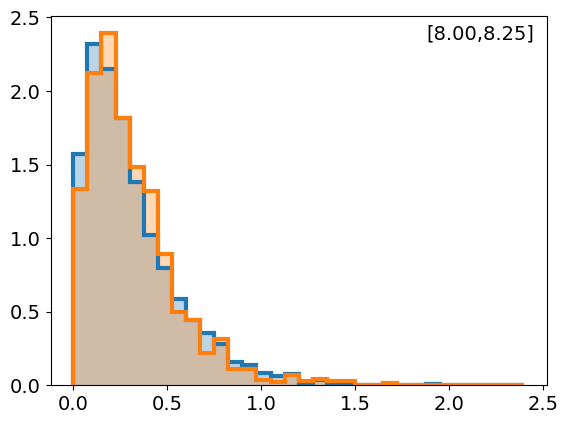

In [49]:
gid = 2

ms_at_mass = np.interp( 0.5*(logmstar_bins[gid-1]+logmstar_bins[gid]), np.log10(ms), np.log10(ha_sfs) )
hkwargs = {'alpha':.3,'lw':3, 'bins':np.arange(0, 42.-ms_at_mass, 0.075), 'density':True}

logmbounds = logmstar_bins[gid-1], logmstar_bins[gid]

pmerger = catalog['p_merger']+catalog['p_ambig']

ek.hist( np.log10(catalog.loc[groups==gid, 'L_Ha']) - ms_at_mass, **hkwargs)
ek.hist( np.log10(catalog.loc[groups==gid, 'L_Ha']) - ms_at_mass, 
         weights=pmerger.loc[groups==gid], **hkwargs)
ek.text(0.975, 0.975, f'[{logmbounds[0]:.2f},{logmbounds[1]:.2f}]')


🎨 Creating classification fraction maps...
💾 Classification fraction maps saved to: ../../local_data/dino_results/classification_fraction_maps.png


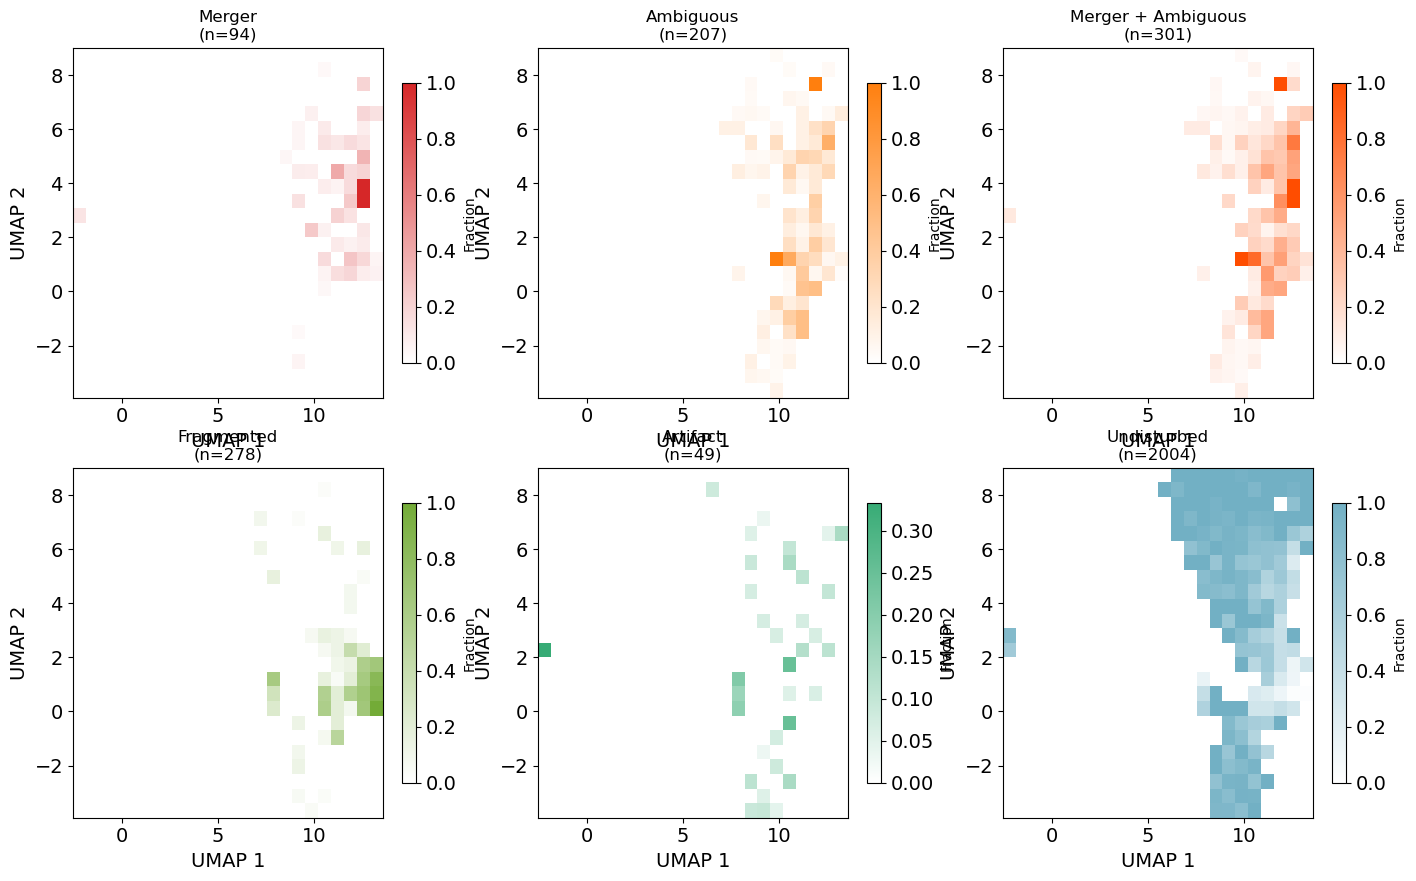

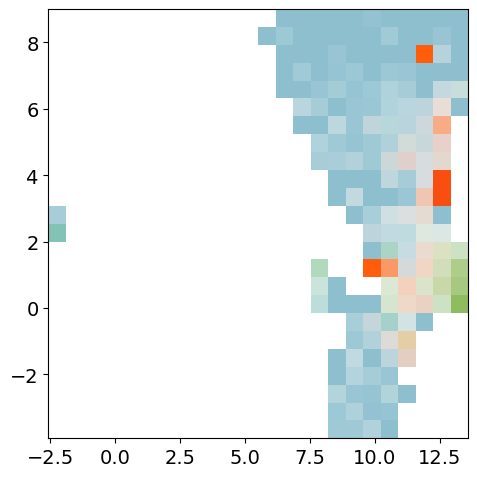

In [44]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import ekfplot.plot as ek
import ekfplot.colors as ec
from ekfstats import sampling



def create_classification_fraction_maps(embeddings_umap, labels, output_path):
    """Create 6-panel classification fraction maps"""
    if labels is None:
        print("⚠️  No labels available for fraction maps")
        return
    
    print("🎨 Creating classification fraction maps...")
    
    # Define classifications and their meanings
    classifications = {
        3: "Merger",
        2: "Ambiguous", 
        'merger_ambiguous': "Merger + Ambiguous",
        4: "Fragmented",
        5: "Artifact",
        1: "Undisturbed"
    }
    color_d = {
        3: 'tab:red',
        2: 'tab:orange',
        'merger_ambiguous': '#ff4d00',
        4: '#73ab37',
        5: '#37ab75',
        1: '#72b0c4',
    }
    
    # Create figure with 2x3 subplots
    fig, axes = plt.subplots(2, 3, figsize=(17, 10))
    fig2 = plt.figure(figsize=(5,5))
    ax2 = fig2.add_subplot(111)
    axes = axes.flatten()
    
    # Get UMAP coordinates
    has_label = labels > 0
    x = embeddings_umap[has_label, 0]
    y = embeddings_umap[has_label, 1]
    
    
    # Define grid parameters for binning
    nbins = 25
    imdict = {}
    for i, (class_key, class_name) in enumerate(classifications.items()):
        ax = axes[i]
        
        # Create binary mask for this classification
        if class_key == 'merger_ambiguous':
            # Combined merger + ambiguous
            mask = (labels == 3) | (labels == 2)
        else:
            # Single classification
            mask = (labels == class_key)
        
        # Convert boolean mask to 0/1 for fraction calculation
        z_values = mask[has_label].astype(float)
        

        try:
            im, axarr = ek.pcolor_avg2d(
                x, y, z_values,
                bins=nbins,
                ax=ax,
                cmap=ec.ColorBase(color_d[class_key]).sequential_cmap()
            )
            _ = ek.pcolor_avg2d(
                x, y, z_values,
                bins=nbins,
                ax=ax2,
                cmap=ec.ColorBase(color_d[class_key]).translucify(0.8).sequential_cmap(fade=0.),
            )            
        except Exception as e:
            print(f"⚠️  ekfplot error for {class_name}: {e}, using fallback")
            # Fallback to manual binning
            im = create_manual_fraction_map(x, y, z_values, ax, nbins)

        # Customize plot
        ax.set_title(f'{class_name}\n(n={np.sum(mask)})', fontsize=12)
        ax.set_xlabel('UMAP 1')
        ax.set_ylabel('UMAP 2')
        
        # Add colorbar
        if im is not None:
            cbar = plt.colorbar(im, ax=ax, shrink=0.8)
            cbar.set_label('Fraction', fontsize=10)

        imdict[class_key] = im
    
    plt.tight_layout()
    
    # Save plot
    output_path.mkdir(parents=True, exist_ok=True)
    plot_path = output_path / 'classification_fraction_maps.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"💾 Classification fraction maps saved to: {plot_path}")
    
    plt.show()
    return imdict

def create_manual_fraction_map(x, y, z_values, ax, nbins):
    """Manual implementation of 2D binned fraction map"""
    from scipy.stats import binned_statistic_2d
    
    # Create 2D histogram with mean values (fractions)
    stat, x_edges, y_edges, _ = binned_statistic_2d(
        x, y, z_values, 
        statistic='mean', 
        bins=nbins
    )
    
    # Create meshgrid for plotting
    X, Y = np.meshgrid(x_edges[:-1], y_edges[:-1])
    
    # Plot
    im = ax.pcolormesh(X, Y, stat.T, cmap='viridis', vmin=0, vmax=1)
    return im

# Create classification fraction maps
if labels is not None:
    imdict = create_classification_fraction_maps(
        reduction_results['embeddings_umap'], 
        labels, 
        config['data']['output_path']
    )
else:
    print("⚠️  Skipping fraction maps - no labels available")


In [ ]:
im = imdict['merger_ambiguous']

In [ ]:
x_mesh = im._coordinates[:, :, 0].data  # x coordinates
x_grid = x_mesh[0]
y_mesh = im._coordinates[:, :, 1].data  # y coordinates
y_grid = y_mesh[:,0]
x_mesh = (x_mesh[:-1, :-1] + x_mesh[:-1, 1:] + 
         x_mesh[1:, :-1] +  x_mesh[1:, 1:]) / 4
y_mesh = (y_mesh[:-1, :-1] + y_mesh[:-1, 1:] + 
         y_mesh[1:, :-1] +  y_mesh[1:, 1:]) / 4
z = im.get_array().data
z = np.where(np.isnan(z), 0., z)

In [ ]:
zindex = np.unravel_index(np.argmax(z), z.shape)
zindices = np.where(z>0.5)
print(len(zindices[0]))
zx = 0
zindex = zindices[0][zx],zindices[1][zx]
poi = x_mesh[zindex], y_mesh[zindex]
print(f'{zindex}, UMAP {poi}')

In [ ]:
ltwonorm = np.sqrt((reduction_results['embeddings_umap'][:,0] - poi[0])**2 + \
                   (reduction_results['embeddings_umap'][:,1] - poi[1])**2 )

In [ ]:
from astropy.visualization import make_lupton_rgb
from matplotlib import colors
from scipy import ndimage

In [ ]:
fig, axarr = plt.subplots(3, 5, figsize=(12,7))

for idx, gix in enumerate(np.argsort(ltwonorm)[:5]):
    ek.imshow(
        images[gix][1],
        ax=axarr[0, idx],
        q=0.01,
        cmap='Greys'
    )
    axarr[1,idx].imshow(
        ndimage.gaussian_filter(images[gix][1], 1),
        origin='lower',
        cmap='Greys',
        norm=colors.LogNorm()
    )
    ek.imshow(
        images[gix][2],
        ax=axarr[2, idx],
        q=0.01,
        cmap='magma'
    )    

for ax in axarr.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

ek.text(0.05,0.95, 'HSC i-band', ax=axarr[0,0], fontsize=12, bordercolor='k', color='w', borderwidth=6 )
ek.text(0.05,0.95, 'HSC i-band (LSB)', ax=axarr[1,0], fontsize=12, bordercolor='k', color='w', borderwidth=6 )
ek.text(0.05,0.95, 'Starlet HF', ax=axarr[2,0], fontsize=12, bordercolor='k', color='w', borderwidth=6 )

In [ ]:
ltwonorm[np.argsort(ltwonorm)[:4]]

## Save Results

Save the extracted embeddings and other results for future use.

In [ ]:
# Create output directory if it doesn't exist
output_path = config['data']['output_path']
output_path.mkdir(parents=True, exist_ok=True)

# Save embeddings
embeddings_path = output_path / 'embeddings.npy'
np.save(embeddings_path, embeddings)
print(f"💾 Embeddings saved to: {embeddings_path}")

# Save reduction results
reduction_path = output_path / 'dimensionality_reduction_results.pkl'
with open(reduction_path, 'wb') as f:
    pickle.dump(reduction_results, f)
print(f"💾 Reduction results saved to: {reduction_path}")

# Save image info for reference
image_info = {
    'img_names': img_names,
    'labels': labels,
    'num_images': len(images)
}
info_path = output_path / 'image_info.pkl'
with open(info_path, 'wb') as f:
    pickle.dump(image_info, f)
print(f"💾 Image info saved to: {info_path}")

## Summary

Final results - loaded images and embeddings ready for analysis.

In [ ]:
print("\n" + "="*60)
print("🎉 DINOv2 ANALYSIS COMPLETE")
print("="*60)
print(f"📸 Loaded images shape: {images.shape}")
print(f"🧠 Extracted embeddings shape: {embeddings.shape}")
print(f"📊 UMAP embeddings shape: {reduction_results['embeddings_umap'].shape}")
print(f"📁 Number of image files: {len(img_names)}")
if labels is not None:
    print(f"🏷️  Classification labels: {len(labels)} objects")
print(f"💾 Results saved to: {output_path}")
print("\n✅ Images and embeddings are now loaded and ready for analysis!")

# Display basic statistics
print(f"\n📊 Embedding Statistics:")
print(f"   Mean: {embeddings.mean():.4f}")
print(f"   Std:  {embeddings.std():.4f}")
print(f"   Min:  {embeddings.min():.4f}")
print(f"   Max:  {embeddings.max():.4f}")

if labels is not None:
    print(f"\n🏷️  Label Statistics:")
    unique, counts = np.unique(labels, return_counts=True)
    label_meanings = {
        0: "unclassified", 1: "undisturbed", 2: "ambiguous",
        3: "merger", 4: "fragmentation", 5: "artifact"
    }
    for label_val, count in zip(unique, counts):
        meaning = label_meanings.get(label_val, f"unknown_{label_val}")
        percentage = 100 * count / len(labels)
        print(f"   {label_val} ({meaning}): {count} ({percentage:.1f}%)")